In [ ]:
import numpy as np  
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mushroom-classification/mushrooms.csv


In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

All data here are not numerical so we have to encode them.

In [3]:
data = pd.read_csv("../input/mushroom-classification/mushrooms.csv")
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
X = data.drop('class', axis=1)
y = data[["class"]]

In [5]:
label_encoder = LabelEncoder()
for i in X.columns:
    X[i] = label_encoder.fit_transform(X[i])
    
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.values.ravel())


In [6]:
X = X.to_numpy()

In [7]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

Had to convert the dtype here to float32 as we ran into a dtype error where X was int and y was Long

In [8]:
X = X.type(torch.float32)
y = y.type(torch.float32)
X.dtype, y.dtype

(torch.float32, torch.float32)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test) 

(6499, 1625, 6499, 1625)

Had 22 Columns of features in X so the first layer had `in_features=22` then decided to scale it into `out_features=50` and finally ended with `1` 
<br/>Also included ReLU here to add non-linearity into the model 

In [10]:
class MushroomModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=22, out_features=50)
        self.layer_2 = nn.Linear(in_features=50, out_features=1)
        self.relu = nn.ReLU()


    def forward(self, x):
        return self.layer_2(self.relu(self.layer_1(x)))


model0 = MushroomModelV0()
model0

MushroomModelV0(
  (layer_1): Linear(in_features=22, out_features=50, bias=True)
  (layer_2): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [12]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()

    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
torch.manual_seed(42)

epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []


for epoch in range(epochs):
    model0.train()

    y_logits = model0(X_train).squeeze() # Added squeeze() here as the loss_fn was throwing a dim error 
    y_pred = torch.round(torch.sigmoid(y_logits))


    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model0.eval()
    with torch.inference_mode():
        test_logits = model0(X_test).squeeze() # Added squeeze() here as the loss_fn was throwing a dim error 
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_accuracy:.2f}%")
        

Epoch: 0 | Loss: 0.77388, Accuracy: 57.22% | Test Loss: 0.69828, Test Accuracy: 52.62%
Epoch: 10 | Loss: 0.50606, Accuracy: 78.90% | Test Loss: 0.50148, Test Accuracy: 78.89%
Epoch: 20 | Loss: 0.50375, Accuracy: 79.54% | Test Loss: 0.49442, Test Accuracy: 75.38%
Epoch: 30 | Loss: 0.42875, Accuracy: 83.58% | Test Loss: 0.42256, Test Accuracy: 81.66%
Epoch: 40 | Loss: 0.41324, Accuracy: 84.95% | Test Loss: 0.41032, Test Accuracy: 80.43%
Epoch: 50 | Loss: 0.39858, Accuracy: 85.64% | Test Loss: 0.38579, Test Accuracy: 82.15%
Epoch: 60 | Loss: 0.36519, Accuracy: 87.07% | Test Loss: 0.36141, Test Accuracy: 84.06%
Epoch: 70 | Loss: 0.36299, Accuracy: 87.12% | Test Loss: 0.35291, Test Accuracy: 84.25%
Epoch: 80 | Loss: 0.33888, Accuracy: 88.14% | Test Loss: 0.33268, Test Accuracy: 86.15%
Epoch: 90 | Loss: 0.32891, Accuracy: 88.77% | Test Loss: 0.32221, Test Accuracy: 86.83%


In [14]:
model0.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model0(X_test))).squeeze()
#y_preds[:10], y[:10]
correct = torch.eq(y_test, y_preds).sum().item()

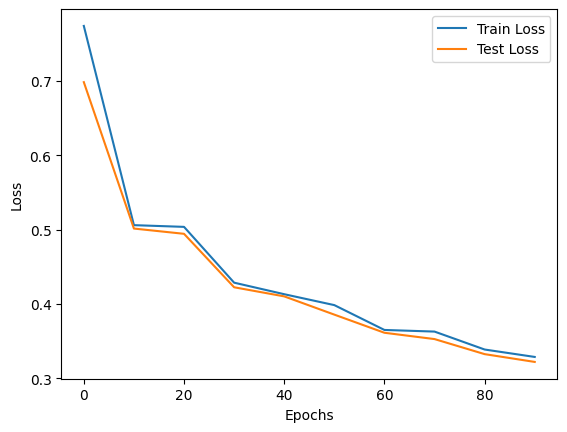

In [15]:
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
from pathlib import Path

MODEL_PATH = Path("\Mushroom-Classification")

MODEL_NAME = "ClassificationModel0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving Model to: {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(), f=MODEL_SAVE_PATH)

Saving Model to: /kaggle/working/ClassificationModel0.pth
